# Inspect Public Green Spaces

In [28]:
import osmnx as ox
from shapely.geometry import box
import geopandas as gpd
import pandas as pd
import shapely
import cv2

In [29]:
from shapely.geometry import box


# Define the bounding box coordinates
north, south, east, west = 43.677542, 43.634644, 39.704246, 39.635672

def get_green_space_areas(north, south, east, west):
    tags = {"leisure": ["park", "nature_reserve", "playground", "garden"],
            "landuse": ["recreation_ground", "meadow", "forest", "grass"],
            "natural": ["wood"]}

    gdf = ox.geometries_from_bbox(north, south, east, west, tags=tags)
    gdf = gdf[(gdf["geometry"].geom_type == "MultiPolygon") | (gdf["geometry"].geom_type == "Polygon")]
    bbox_polygon = gpd.GeoDataFrame({'geometry': [box(west, south, east, north)]}, crs=gdf.crs)
    gdf = gpd.overlay(bbox_polygon, gdf, how='intersection')
    gdf = gdf.to_crs({'init': 'epsg:3857'})
    green_rate = sum(gdf.geometry.area)

    return green_rate, gdf

green_rate, gdf = get_green_space_areas(north, south, east, west)
print(green_rate)

16659023.198650064


c:\anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


# Overlay

In [30]:
from shapely.affinity import scale
sindex = gdf.sindex

intersections = []

for i, poly in enumerate(gdf.geometry):

    neighbors = list(sindex.intersection(poly.bounds))
    for j in neighbors:
        if i < j:
            if gdf.geometry[i].intersects(gdf.geometry[j]):
                intersection = gdf.geometry[i].intersection(gdf.geometry[j])
                intersections.append(intersection)


gdf_intersections = gpd.GeoDataFrame(geometry=intersections, crs=3857)


In [31]:
gdfm = gdf.copy()
for poly in gdf_intersections.geometry:
    gdfm = gdfm.difference(poly)
gdfm = pd.concat([gpd.GeoDataFrame(geometry=gdfm).to_crs(3857), gdf_intersections.to_crs(3857)], ignore_index=True)

In [32]:
gdfm['geometry'].explore()

# Union

In [33]:
g =  gpd.GeoSeries(shapely.ops.unary_union(gdf.geometry))
gdf_intersection = gpd.GeoDataFrame(geometry = g, crs=3857 )

In [34]:
gdf_intersection.explore()

# SentinelHub connection

Здесь мы подключаемся к SentinelHub и выгружаем снимок для конкретного участка на карте. Выгружается не просто один снимок, а мозайка из снимков, для минимизации мутных изображений из-за облаков.

In [589]:
from sentinelhub import SHConfig

config = SHConfig()

config.sh_client_id = '37a2ea34-f165-499e-836d-665c81d887a7'
config.sh_client_secret = f'bTjE@Cw#e/X+#V]NZFhV>Y~uVY,xN)B%4i+/u[?_'

config.save("my-profile")

In [590]:
config = SHConfig("my-profile")

In [591]:
import datetime
import os

import matplotlib.pyplot as plt
import numpy as np

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)

# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
# from utils import plot_image

In [592]:
# Sochi : 39.15,43.38,40.12,44.03
betsiboka_coords_wgs84 = (39.806638,43.531032,39.838096,43.552844)  # (46.16, -16.15, 46.51, -15.58)

resolution = 10
betsiboka_bbox = BBox(bbox=betsiboka_coords_wgs84, crs=CRS.WGS84)
betsiboka_size = bbox_to_dimensions(betsiboka_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {betsiboka_size} pixels")

evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2022-06-01", "2022-06-30"),
            mosaicking_order=MosaickingOrder.LEAST_CC,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=betsiboka_bbox,
    size=betsiboka_size,
    config=config,
)

true_color_imgs = request_true_color.get_data()

Image shape at 10 m resolution: (252, 245) pixels


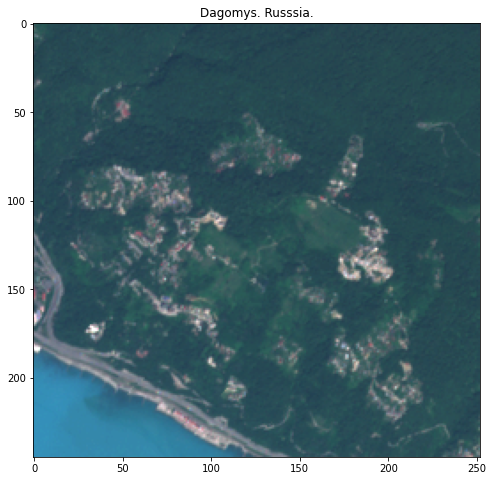

In [593]:
import matplotlib.pyplot as plt

def convert_image(img, factor):
    img = factor / 255 * img
    img = np.where(img > 1, 1, img)
    img = np.where(img < 0, 0, img)
    return img
img = convert_image(true_color_imgs[0], 3.5)
plt.figure(figsize=(8, 8))
plt.title("Dagomys. Russsia.")
plt.imshow(img);

In [594]:
img_copy = img.copy()
heat_map = np.zeros((img.shape[0], img.shape[1]))
for x in range(img.shape[0]):
    for y in range(img.shape[1]):
        if img[x, y, 1] > img[x, y, 0] and img[x, y, 1] > img[x, y, 2]:
            img_copy[x, y, 0], img_copy[x, y, 2] = 0, 0
            
        heat_map[x, y] = np.linalg.norm(img[x, y, :] - [0, 1, 0])
#         a, b = img[x, y, :], [0, 1, 0]
#         heat_map[x, y] = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

c:\anaconda3\lib\site-packages\seaborn\rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\anaconda3\lib\site-packages\setuptools\_distutils\version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
c:\anaconda3\lib\site-packages\seaborn\cm.py:1582: PendingDeprecationWarning: The register_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps.register(name)`` instead.
  mpl_cm.register_cmap(_name, _cmap)
c:\anaconda3\lib\site-packages\seaborn\cm.py:1583: PendingDeprecationWarning: The register_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps.register(name)`` instead.
  mpl_cm.register_cmap(_name + "_r", _cmap_r)


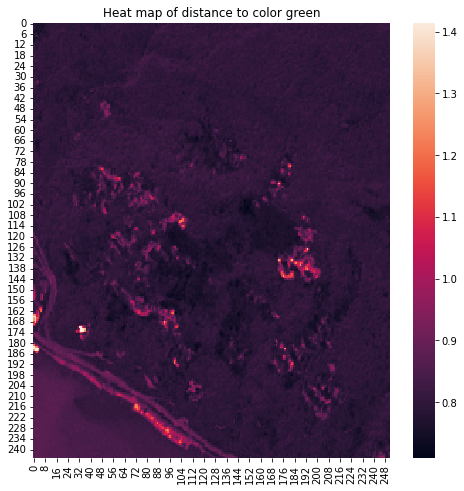

In [595]:
import seaborn as sns

plt.figure(plt.figure(figsize=(8, 8)))
plt.title("Heat map of distance to color green")
sns.heatmap(heat_map);

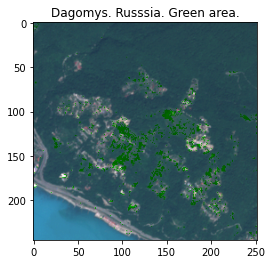

In [596]:
plt.figure()
plt.title("Dagomys. Russsia. Green area.")
plt.imshow(img_copy);

In [597]:
import cv2

img_raw = (img * 255).astype(int)

# Threshold the hue and saturation channels# Set the lower and upper green color thresholds
lower_green = np.array([60, 50, 50])
upper_green = np.array([150, 255, 255])

# Create a binary mask of the green pixels
mask = cv2.inRange(img_raw, lower_green, upper_green)

# Apply the binary mask to the original image
green_pixels = cv2.bitwise_and(img_raw, img_raw, mask=mask)

In [598]:
img_raw[220, 23], mask[220, 23]

(array([ 52, 136, 171]), 0)

In [599]:
all(img_raw[50, 220] >= lower_green) and all(img_raw[50, 220] <= upper_green)

False

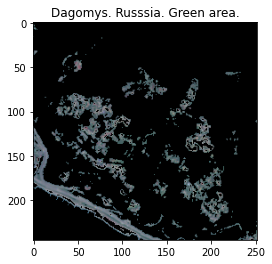

In [600]:
plt.figure()
plt.title("Dagomys. Russsia. Green area.")
plt.imshow(green_pixels);

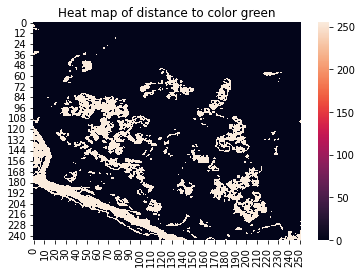

In [601]:
plt.figure()
plt.title("Heat map of distance to color green")
sns.heatmap(mask);

In [602]:
mask.shape

(245, 252)

In [603]:
heat_map = np.ones((img_raw.shape[0], img_raw.shape[1]))
for x in range(img_raw.shape[0]):
    for y in range(img_raw.shape[1]):     
        if all(img_raw[x, y, :] >= lower_green) and all(img_raw[x, y, :] <= upper_green):
            heat_map[x, y] = 0

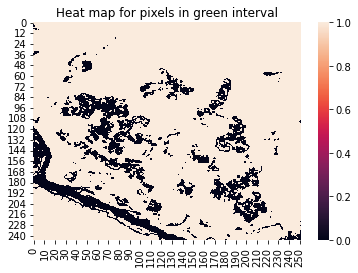

In [604]:
plt.figure()
plt.title("Heat map for pixels in green interval")
sns.heatmap(heat_map);

In [605]:
shape = heat_map.shape[1] * heat_map.shape[0]

total_area = sum(sum(heat_map)) / shape
print("Green rate for current area:", total_area)

Green rate for current area: 0.8542274052478134


# HSV experiments

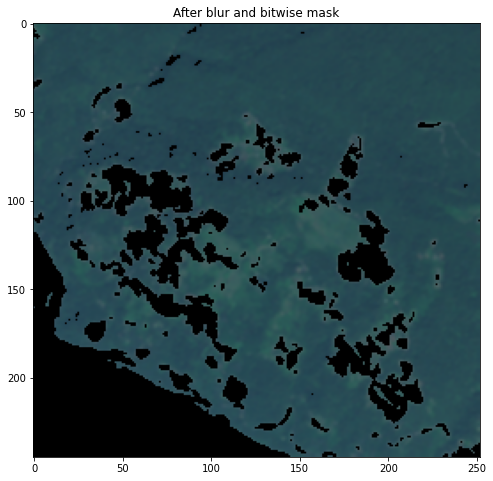

In [629]:
image = (img * 255).astype(np.uint8)
image = cv2.GaussianBlur(image, (3,3), 0)
hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
lower = np.array([0, 0, 0])
upper = np.array([100, 255, 98])
mask = cv2.inRange(hsv, lower, upper)
result = cv2.bitwise_and(image, image, mask=mask)

plt.figure(figsize=(8, 8))
plt.title("After blur and bitwise mask")
plt.imshow(result);

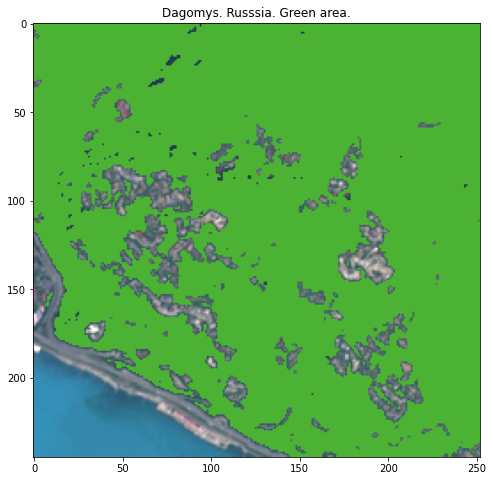

In [630]:
img_copy = img.copy()
heat_map = np.zeros((img.shape[0], img.shape[1]))
img_copy[np.all(result > 0, axis=2)] = (0.3, 0.7, 0.2)


plt.figure(figsize=(8, 8))
plt.title("Dagomys. Russsia. Green area.")
plt.imshow(img_copy);


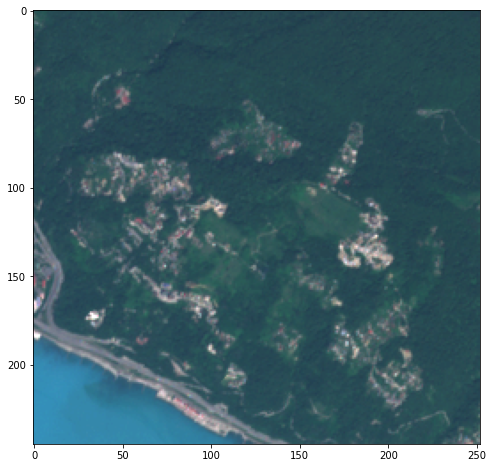

In [621]:
plt.figure(figsize=(8, 8))
plt.imshow(img);

## Cut the image by the polygon

In [613]:
polygon = gdf.iloc[3].geometry
stretched_polygon = scale(polygon, xfact=100, yfact=100)
bbox_polygon = gpd.GeoDataFrame({'geometry': [stretched_polygon]}, crs=gdf.crs)
small_bbox = scale(bbox.iloc[0].geometry, xfact=0.5, yfact=0.5)
small_bbox = gpd.GeoDataFrame({'geometry': [small_bbox]}, crs=gdf.crs)

NameError: name 'bbox' is not defined

In [ ]:
from shapely.geometry import Point

point = Point(west, south)
data = np.array(img)

for y, lat in enumerate(np.linspace(west, east, data.shape[1])):
    for x, lon in enumerate(np.linspace(south, north, data.shape[0])):
        point = Point(lat, lon)
        is_inside = small_bbox.geometry.contains(point).values[0]
        if not is_inside:
            data[x, y] = 0

## Save the image to the local folder.

In [251]:
heat_map[:100]

TypeError: 'int' object is not subscriptable

In [142]:
from PIL import Image

# convert the numpy array to a PIL Image object
img_array = np.interp(img, (0, 1), (0, 255)).astype(np.uint8)
image = Image.fromarray(img_array)

# save the image to a jpg file on local storage
image.save("example.jpg")

In [ ]:
np.interp(img, (0, 1), (0, 255)).astype(np.uint8)

## Cut Polygons out